# 生成混淆矩阵

In [3]:
import os 
import pickle

In [ ]:

# tmp
from mmaction.apis import init_recognizer, inference_recognizer

configfile = 'slowonly_r50_u48_240e_ntu60_xsub_keypoint_4labels.py'
# configfile = '/mmaction2/filling_exps/TimeSformer/timesformer.py'
checkpoint_file = '../checkpoints/ntu60_keypoints_4labels.pth'
# checkpoint_file = '/mmaction2/filling_exps/TimeSformer/latest.pth'
model = init_recognizer(configfile, checkpoint_file, device='cuda:0')
# test a single video and show the result:
# video = 'filling/val/yBR4FSgI.mp4'
# label = '/mmaction2/filling/label_map_1.txt'
y_pred = []
y_true = []

with open('/home/fate/openmmlab/mmaction2/data/pkls/0.pkl', 'rb') as f:
    anno = pickle.load(f)
    print(anno)
#     for anno in annos:
#         y_true.append(anno['label'])
#         results = inference_recognizer(model, anno)
#         infer_res = results[0][0]
#         y_pred.append(infer_res)

# assert len(y_pred) == len(y_true)

# len(y_true)


In [4]:
from mmaction.apis import init_recognizer, inference_recognizer

configfile = 'slowonly_r50_u48_240e_ntu60_xsub_keypoint_4labels.py'
# configfile = '/mmaction2/filling_exps/TimeSformer/timesformer.py'
checkpoint_file = '../checkpoints/ntu60_keypoints_4labels.pth'
# checkpoint_file = '/mmaction2/filling_exps/TimeSformer/latest.pth'
model = init_recognizer(configfile, checkpoint_file, device='cuda:0')
# test a single video and show the result:
# video = 'filling/val/yBR4FSgI.mp4'
# label = '/mmaction2/filling/label_map_1.txt'
y_pred = []
y_true = []

with open('../data/val_label0-3.pkl', 'rb') as f:
    annos = pickle.load(f)
    for anno in annos:
        y_true.append(anno['label'])
        results = inference_recognizer(model, anno)
        infer_res = results[0][0]
        y_pred.append(infer_res)

assert len(y_pred) == len(y_true)

len(y_true)


load checkpoint from local path: ../checkpoints/ntu60_keypoints_4labels.pth


49

In [5]:
TP = 0
for pred,true in zip(y_pred,y_true):
    if pred == true:
        TP += 1
    
acc = TP / len(y_true)
acc

0.5714285714285714

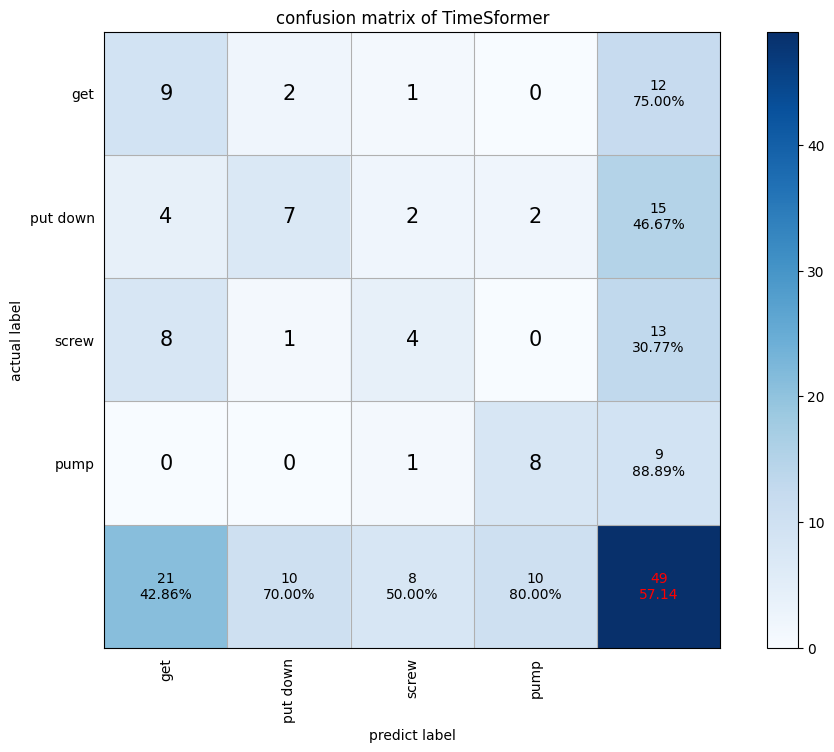

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import json

# classes = ['bagan','filling','touch the box']
# classes = ['get','put down','screw','pump','Bucket filling','other filling','touch the box']
classes = ['get','put down','screw', 'pump']
#计算混淆矩阵，FP，FN，TP，TN，PRECISION，RECALL
cm = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

FP = sum(cm.sum(axis=0)) - sum(np.diag(cm)) #假正样本数
FN = sum(cm.sum(axis=1)) - sum(np.diag(cm)) #假负样本数
TP = sum(np.diag(cm)) #真正样本数
TN = sum(cm.sum().flatten()) - (FP + FN + TP) #真负样本数
SUM = TP+FP
PRECISION = TP / (TP+FP)  # 查准率，又名准确率
RECALL = TP / (TP+FN)  # 查全率，又名召回率

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'): #绘制混淆矩阵
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)
    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes)+1)
    x, y = np.meshgrid(ind_array, ind_array)#生成坐标矩阵
    diags = np.diag(cm)#对角TP值
    TP_FNs, TP_FPs = [], []
    for x_val, y_val in zip(x.flatten(), y.flatten()):#并行遍历
        max_index = len(classes)
        if x_val != max_index and y_val != max_index:#绘制混淆矩阵各格数值
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, c, color='black', fontsize=15, va='center', ha='center')
        elif x_val == max_index and y_val != max_index:#绘制最右列即各数据类别的查全率
            TP = diags[y_val]
            TP_FN = cm.sum(axis=1)[y_val]
            recall = TP / (TP_FN)
            if recall != 0.0 and recall > 0.01:
                recall = str('%.2f'%(recall*100,))+'%'
            elif recall == 0.0:
                recall = '0'
            TP_FNs.append(TP_FN)
            plt.text(x_val, y_val, str(TP_FN)+'\n'+str(recall), color='black', va='center', ha='center')
        elif x_val != max_index and y_val == max_index:#绘制最下行即各数据类别的查准率
            TP = diags[x_val]
            TP_FP = cm.sum(axis=0)[x_val]
            precision = TP / (TP_FP)
            if precision != 0.0 and precision > 0.01:
                precision = str('%.2f'%(precision*100,))+'%'
            elif precision == 0.0:
                precision = '0'
            TP_FPs.append(TP_FP)
            plt.text(x_val, y_val, str(TP_FP)+'\n'+str(precision), color='black', va='center', ha='center')
    cm = np.insert(cm,max_index,TP_FNs,1)
    cm = np.insert(cm,max_index,np.append(TP_FPs,SUM),0)
    plt.text(max_index, max_index, str(SUM)+'\n'+str('%.2f'%(PRECISION*100,)), color='red', va='center', ha='center')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('actual label')
    plt.xlabel('predict label')
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    #plt.gcf().subplots_adjust(bottom=0.15)
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

plot_confusion_matrix(cm, 'cm_test.png', title='confusion matrix of TimeSformer')
